# A Demonstration as NDCube as SunPy Map

This notebook shows how you would use `NDCube` from `ndcube 2.0` to perform some of the same tasks as sunpy map.  It is divided into four sections.

## Introductory Information

### Scope of this Notebook

The `ndcube` package has 3 main data classes: `NDCube` for single data arrays described by a single set of WCS transformations; `NDCubeSequence` for handling an ordered sequence of `NDCube` objects; and `NDCollection` for handling an unordered collection of `NDCube` or `NDCubeSequence` objects.  This notebook will focus on the `NDCube` and its comparison to `sunpy.map.Map`.  To learn more about all these data classes, see the ndcube docs: https://docs.sunpy.org/projects/ndcube/en/latest/data_classes.html

### Generalization of this Demo

While this notebook focuses on image data, all features demonstrated here are agnostic to the physical type.  This means that it should work equally well with **spectral, polarization, temporal, celestial**, or any other type of data so long its described by a valid (APE-14) WCS object.

### Layout of this Notebook

#### Equivalent Functionalities
We will demonstrate how to perform the following equivalent functionalities in both `Map` and `NDCube`:
* Instantiating
* Accessing the data
* Plotting
* Cropping/Submapping

#### Extending to Higher Dimensions
We will show how NDCube allows the data to be extended to higher dimensions by creating a 3-D cube of representing 4 images described by a single WCS.  We will then
* Animating
* Cropping

#### Extra Functionalities Provided by NDCube
This section introduces
* Slicing
* Retrieving Coordinates
* `.global_coords`: enabling scalar coordinates, associated with the cube as a whole rather than any array axis, to be attached to the `NDCube`.
* `.extra_coords`: enabling additional coordinates not described by the primary WCS to be associated with array axes.

#### Functionalities Not Supported by ndcube
These are divided into two groups: those that will be supported in ndcube 2.0 but will be in later versions; those that do not intend to ever be supported.

## Installation

This notebook requires the beta version of ndcube 2.0.  To install, do

```pip install --pre ndcube```

## Known Bugs

* `NDCube.axis_world_coords()` breaks when there are only two dimensions that are coupled, e.g. for a 2-D Map.  This will be fixed by the release of 2.0.

# Demo

In [1]:
import astropy.units as u
import astropy.wcs
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import sunpy.data.sample
import sunpy.map
from astropy.coordinates import SkyCoord, SpectralCoord
from astropy.time import Time
from astropy.visualization.wcsaxes import WCSAxes

from ndcube import NDCube, GlobalCoords, ExtraCoords

In [2]:
#%matplotlib notebook

In [3]:
# A bug was found in NDCube.axis_world_coords, specifically for 2-D cubes with dependent axes, i.e. a Map!
# Build a function to mimic its behavior for a 2-D celestial cube.
# The bug will be fixed by the release of 2.0.

import numbers
import astropy.wcs

def cube_axis_world_coords(*axes, edges=False, wcs=None):
    """Mimics behavior of NDCube.axis_world_coords.
    
    Necessary because a bug in NDCube.axis_world_coords has recently been found.
    This function will demonstrate the expected working behaviour."""
    for axis in axes:
        if not (axis == 0 or axis == 1 or axis in cube.wcs.world_axis_physical_types[0] or 
                axis in cube.wcs.world_axis_physical_types[1]):
            raise ValueError(f"axes argument not recognized: {axis}")
    coords_values = cube.axis_world_coords_values(edges=edges, wcs=wcs)
    tx = coords_values.custom_pos_helioprojective_lon
    ty = coords_values.custom_pos_helioprojective_lat
    frame = astropy.wcs.utils.wcs_to_celestial_frame(cube.wcs)
    return SkyCoord(Tx=coords_values.custom_pos_helioprojective_lon,
                    Ty=coords_values.custom_pos_helioprojective_lat,
                    frame=frame)

## Equivalent Functionalities

### Instantiating a Map and NDCube

In [4]:
filename = sunpy.data.sample.AIA_171_IMAGE
filename

'/home/danny/.local/share/sunpy/AIA20110607_063302_0171_lowres.fits'

In [5]:
# Define AIA Map from FITS file.
aia_map = sunpy.map.Map(filename)

In [64]:
# Create data array and WCS object from FITS file.
with astropy.io.fits.open(filename) as hdulist:
    data = hdulist[1].data
    wcs = astropy.wcs.WCS(hdulist[1].header)

# Instantiate NDCube using data array and WCS.
cube = NDCube(data=data, wcs=wcs, unit=u.ct)

In [65]:
cube.unit

Unit("ct")

### Getting at the Data

#### Data

Both `NDCube` and `Map` store the data array at `.data` and the data mask at `.mask`.  Although as we did not instantiate the Map or NDCube with a mask, they will be `None` in this example.

In [7]:
aia_map.data

array([[ -95.92475  ,    7.076416 ,   -1.9656711, ..., -127.96519  ,
        -127.96519  , -127.96519  ],
       [ -96.97533  ,   -5.1167884,    0.       , ...,  -98.924576 ,
        -104.04137  , -127.919716 ],
       [ -93.99607  ,    1.0189276,   -4.0757103, ...,   -5.094638 ,
         -37.95505  , -127.87541  ],
       ...,
       [-128.01454  , -128.01454  , -128.01454  , ..., -128.01454  ,
        -128.01454  , -128.01454  ],
       [-127.899666 , -127.899666 , -127.899666 , ..., -127.899666 ,
        -127.899666 , -127.899666 ],
       [-128.03072  , -128.03072  , -128.03072  , ..., -128.03072  ,
        -128.03072  , -128.03072  ]], dtype=float32)

In [8]:
cube.data

array([[ -95.92475  ,    7.076416 ,   -1.9656711, ..., -127.96519  ,
        -127.96519  , -127.96519  ],
       [ -96.97533  ,   -5.1167884,    0.       , ...,  -98.924576 ,
        -104.04137  , -127.919716 ],
       [ -93.99607  ,    1.0189276,   -4.0757103, ...,   -5.094638 ,
         -37.95505  , -127.87541  ],
       ...,
       [-128.01454  , -128.01454  , -128.01454  , ..., -128.01454  ,
        -128.01454  , -128.01454  ],
       [-127.899666 , -127.899666 , -127.899666 , ..., -127.899666 ,
        -127.899666 , -127.899666 ],
       [-128.03072  , -128.03072  , -128.03072  , ..., -128.03072  ,
        -128.03072  , -128.03072  ]], dtype=float32)

In [9]:
aia_map.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.00089530541880571  0.00038493926472938695  
CRPIX : 512.5  512.5  
PC1_1 PC1_2  : 0.9999970644808501  0.0024230207763071276  
PC2_1 PC2_2  : -0.0024230207763071276  0.9999970644808501  
CDELT : 0.0006674422222222221  0.0006674422222222221  
NAXIS : 1024  1024

In [10]:
cube.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.00089530541880571  0.00038493926472938695  
CRPIX : 512.5  512.5  
NAXIS : 1024  1024

In [11]:
aia_map.mask, cube.mask

(None, None)

`NDCube` also allows you to attach an uncertainty array giving the uncertainty for each pixel.  In this case however, we did not instantiate `cube` with an uncertainty array and so it is `None`.

In [12]:
cube.uncertainty

#### Dimensions

Inspecting the number and length of data dimensions is the same for `Map` and `NDCube`.  The only difference is `Map` returns a `PixelPair` in `x` and `y`.  Because `NDCube` can handle any number of dimensions, it returns a `Quantity` in pixel units.

In [13]:
aia_map.dimensions

PixelPair(x=<Quantity 1024. pix>, y=<Quantity 1024. pix>)

In [16]:
cube.dimensions, cube.data.shape

(<Quantity [1024., 1024.] pix>, (1024, 1024))

The dimensions are order in array order, i.e. `cube.dimensions == cube.data.shape` and vice versa.

#### Physical Types

The `.array_axis_physical_types` property gives the physical types associated with each array axis.  Because more than one physical type can be associated with an array axis, this property returns as a `list` of `tuple`s where each `tuple` contains strings of the associated physical types.  The ordering is the same as the data array axis ordering.  So the first `tuple` corresponds to the first data array axis, and so on.

In [17]:
cube.array_axis_physical_types

[('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

### Plotting

The plotting functionality is written as a mixin class.  This means it's possible to replace the plotting suite with your own.  Nonetheless, NDCube has its own default plotting suite which we will briefly discuss here.

#### 2-D Image Plots

For 2-D static images, the plotting API between `Map` and `NDCube` are almost the same.  However, `NDCube` does not do any scaling or prettifying based on the metadata.

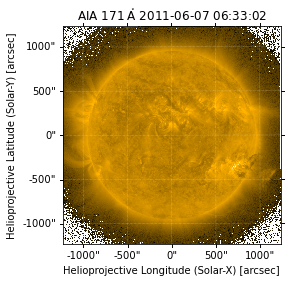

In [18]:
ax_map = aia_map.plot(norm=colors.LogNorm())

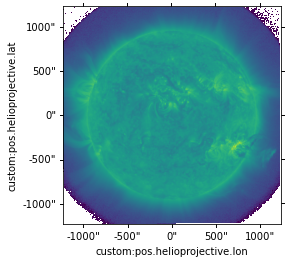

In [19]:
ax_cube = cube.plot(norm=colors.LogNorm())

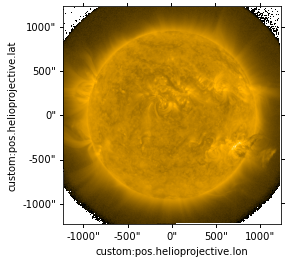

In [20]:
# Get AIA 171 color map
cmap_aia171 = plt.get_cmap('sdoaia171')

ax_cube = cube.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

The biggest different here is that `Map.plot` returns an `AxesImage` object while `NDCube.plot` returns a `WCSAxes` object.

In [21]:
# Returned types:
print(type(ax_map), type(ax_cube))

<class 'matplotlib.image.AxesImage'> <class 'matplotlib.axes._subplots.WCSAxesSubplot'>


However the `AxesImage` object can still easily by retrieved.

In [22]:
# AxesImage can be retrieved from NDCube.plot output.
axes_image = ax_cube.get_images()[0]
type(axes_image)

matplotlib.image.AxesImage

### Submap vs. Cropping

`NDCube`'s equivalent method to `Map.subplot` is `.crop`.  The APIs are almost same API.  The only difference is that the coordinate objects must be wrapped in a `tuple` for `NDCube.crop`.  This is because multiple high level coordinate objects may be required by `NDCube.crop`.  For example, is the `cube` is space-space-time, a `SkyCoord` and a `Time` object will be needed to describe each corner in real world coordinates.

In [23]:
bottom_left_skycoord = SkyCoord(Tx=-900 * u.arcsec, Ty=-900 * u.arcsec, frame=aia_map.coordinate_frame)
top_right_skycoord = SkyCoord(Tx=0 * u.arcsec, Ty=-200 * u.arcsec, frame=aia_map.coordinate_frame)

aia_submap = aia_map.submap(bottom_left_skycoord, top_right=top_right_skycoord)

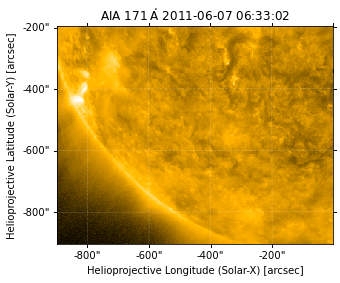

In [24]:
aia_submap.plot()

In [25]:
# Almost same API as submap, except high level coordinate objects must be wrapped in tuples.
# See below for explanation.
cropped_cube = cube.crop((bottom_left_skycoord,), (top_right_skycoord,))

Currently the `SkyCoord`s have to wrapped in a `tuple` because more than one coordinate object may be required to define each corner, e.g. if there is also a spectral axis.  However, before 2.0 is released, this will be relaxed for cases where only one coordinate object is needed, e.g. in the case of `Map`.  In the above case, the API would become the same as `Map`.

<WCSAxesSubplot:>

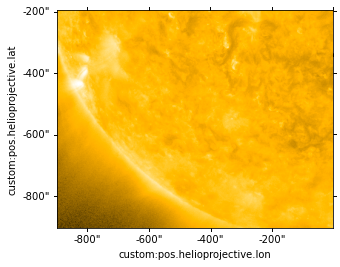

In [26]:
cropped_cube.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

## Extending to Higher Dimensions with NDCube

In [27]:
# Define data cube for 4 images.
fluctuations_lims = (-1, 1)
data3d = np.zeros(tuple([4] + list(data.shape)))
data3d[0] = aia_map.data
data3d[1] = aia_map.data * (1 + np.random.uniform(*fluctuations_lims, aia_map.data.shape))
data3d[2] = aia_map.data * (1 + np.random.uniform(*fluctuations_lims, aia_map.data.shape))
data3d[3] = aia_map.data * (1 + np.random.uniform(*fluctuations_lims, aia_map.data.shape))

# Generate WCS for data cube using same WCS celestial information from AIA map.
wcs_header = wcs.to_header()
wcs_header["WCSAXES"] = 3
wcs_header["CRPIX3"] = 4
wcs_header["CDELT3"] = 12
wcs_header["CUNIT3"] = 's'
wcs_header["CTYPE3"] = "TIME"
wcs_header["CRVAL3"] = 0.
wcs_header["CRPIX3"] = 0
wcs_header["MJDREF"] = wcs_header["MJD-OBS"]
wcs3d = astropy.wcs.WCS(wcs_header)

# Generate NDCube
cube3d = NDCube(data=data3d, wcs=wcs3d)

In [28]:
cube3d.dimensions

<Quantity [   4., 1024., 1024.] pix>

In [29]:
cube3d.array_axis_physical_types

[('time',),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

### Animating

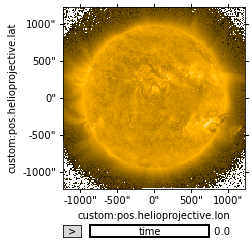

In [30]:
cube3d.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

In [ ]:
cube3d.plot(plot_axes=['x', 'y', None], aspect="auto", norm=colors.LogNorm(), cmap=cmap_aia171)

In [ ]:
cube3d.plot(plot_axes=[None, None, 'x'])

### Cropping

Now that we have a time dimension we need a `SkyCoord` and a `Time` object to define each corner when using `NDCube.crop`.

In [31]:
time_range = Time(['2011-06-07T06:33:25', '2011-06-07T06:33:40'], format="fits")

Crop the cube using SkyCoords and Time objects.  Each `corner` input must be a `tuple` or `list` and the coordinate objects within them must be entered in `WORLD ORDER`, i.e. the same order given by:

So in our case the order should be `(SkyCoord, Time)`.  Let's crop.

In [32]:
lower_corner = (bottom_left_skycoord, time_range[0])
upper_corner = (top_right_skycoord, time_range[-1])

cropped3d = cube3d.crop(lower_corner, upper_corner)
cropped3d

NDCube
------
Dimensions: [  2. 294. 374.] pix
Physical Types of Axes: [('time',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

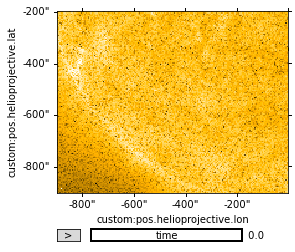

In [33]:
cropped3d.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

In [36]:
cube3d.wcs.world_axis_object_classes.keys()

dict_keys(['celestial', 'time'])

In [37]:
cube3d.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.00089530541880571  0.00038493926472939  0.0  
CRPIX : 512.5  512.5  0.0  
PC1_1 PC1_2 PC1_3  : 0.99999706448085  0.0024230207763071  0.0  
PC2_1 PC2_2 PC2_3  : -0.0024230207763071  0.99999706448085  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00066744222222222  0.00066744222222222  12.0  
NAXIS : 0  0

If you don't want to crop an axis, you can enter `None` instead of a coordinate object.  Let's say we only want to crop by time:

In [38]:
cropped3d = cube3d.crop((None, time_range[0]), (None, time_range[-1]))
cropped3d

NDCube
------
Dimensions: [   2. 1024. 1024.] pix
Physical Types of Axes: [('time',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

## Extra Functionalities Provided by NDCube

### Slicing

NDCube also allows slicing by array indices using the standard slicing API.

In [39]:
cube.dimensions

<Quantity [1024., 1024.] pix>

In [40]:
sliced_cube = cube[512:1000, 24:512]

In [41]:
sliced_cube.dimensions

<Quantity [488., 488.] pix>

<WCSAxesSubplot:>

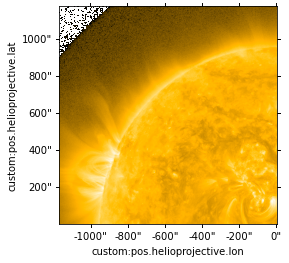

In [42]:
sliced_cube.plot(norm=colors.LogNorm(), cmap=cmap_aia171)

In [43]:
cube3d[:, 512:1000, 24:512]

NDCube
------
Dimensions: [  4. 488. 488.] pix
Physical Types of Axes: [('time',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

#### Reducing Dimensionality

Slicing reduces the dimensionality of an `NDCube` if an axis is indexed with an `int`.

In [44]:
cube1d = cube[512]
cube1d

NDCube
------
Dimensions: [1024.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

Note there is now only 1 dimension.  This will cause the `.plot` method to produce a line plot.

<WCSAxesSubplot:ylabel='Data'>

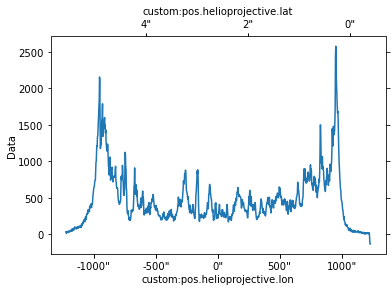

In [45]:
cube1d.plot()

### Retrieving Coordinates

Now `NDCube.axis_world_coords` will return a `SkyCoord` and a `Time` object and the WCS contains celestial and temporal components.

In [46]:
cube3d.axis_world_coords()

(<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     [[(-1228.76466158, -1224.62447509), (-1226.36196228, -1224.63038192),
       (-1223.95926264, -1224.63628858), ...,
       ( 1224.44975018, -1230.56881707), ( 1226.85245064, -1230.57455382),
       ( 1229.25515076, -1230.58029041)],
      [(-1228.75883987, -1222.22181793), (-1226.35614057, -1222.22772459),
       (-1223.95344093, -1222.23363109), ...,
       ( 1224.45557209, -1228.16615958), ( 1226.85827254, -1228.1718965 ),
       ( 1229.26097267, -1228.17763325)],
      [(-1228.75301816, -1219.81916044), (-1226.35031885, -1219.82506693),
       (-1223.94761922, -1219.83097326), ...,
       ( 1224.46139399, -1225.76350175), ( 1226.86409445, -1225.76923884),
       ( 1229.26679457, -1225.77497576)],
      ...,
      [(-1222.82069357,  1228.5464895 ), (-1220.41799325,  1228.54075277),
       (-1218.0152926 ,  1228.53501588), ...,
       ( 1230.39391586,  1222.60248691)

If you only want the temporal coordinates, you can input a unique substring of the desired physical type.  The physical types can be seen at `NDCube.wcs.world_axis_physical_types`:

In [47]:
cube3d.wcs.world_axis_physical_types

['custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'time']

In [48]:
cube3d.axis_world_coords("tim")

(<Time object: scale='utc' format='mjd' value=[55719.27308762 55719.2732265  55719.27336539 55719.27350428]>,)

Equivalently, you can give the array axis index for which you want the world coords.

In [49]:
cube3d.axis_world_coords(0)

(<Time object: scale='utc' format='mjd' value=[55719.27308762 55719.2732265  55719.27336539 55719.27350428]>,)

### ExtraCoords

Enables additional coordinates not included in the WCS to be associated with 1 or more axes.  Let's say each image in our 3-D `NDCube` was also taken at a different wavelength.  As this is not described by the primary WCS, we can add it as an extra coordinate.

In [50]:
# An ExtraCoords object is available at NDCube.extra_coords.
# By default, it is instantiated as empty.
cube3d.extra_coords

In [51]:
# Let's add a wavelength extra coordinate along the time axis.

ec_name = "wavelength"  # Define name of coordinate

ec_axis = 2  # This is the axis to which extra coords.
# Currently ec_axis is required in world order but will be required in array order by the release of 2.0.
# When that change is made, ec_axis should be set to 0 rather than 2.  Hopefully this is more intuitive.

ec_values = [94, 171, 193, 304] * u.AA  # Define the wavelength value at each value along the time axis.

# To add the coordinate, supply the name, axis and values of the coordinate to the .add method.
cube3d.extra_coords.add_coordinate(ec_name, ec_axis, ec_values)

In [52]:
# The names of extra coordinates can be seen via the .keys() method.
cube3d.extra_coords.keys()

('wavelength',)

In [53]:
# The extra coordinates are also visible via NDCube.array_axis_physical_types.
cube3d.array_axis_physical_types

[('time', 'custom:SPATIAL'),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'),
 ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

#### Combined WCS

The extra coordinates are combined with those in the primary WCS via the combined_wcs property.

In [54]:
cube3d.combined_wcs

CompoundLowLevelWCS Transformation

This transformation has 3 pixel and 4 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None
        2  None            None  None

World Dim  Axis Name   Physical Type                   Units
        0  None        custom:pos.helioprojective.lon  deg
        1  None        custom:pos.helioprojective.lat  deg
        2  None        time                            s
        3  wavelength  custom:SPATIAL                  Angstrom

Correlation between pixel and world axes:

             Pixel Dim
World Dim    0    1    2
        0  yes  yes   no
        1  yes  yes   no
        2   no   no  yes
        3   no   no  yes

`.combined_wcs` can be used instead of the primary WCS in many `NDCube` methods.  For example, the values of extra coords can be retrieved via `NDCube.axis_world_coords`!

In [55]:
cube3d.axis_world_coords("custom:SPATIAL", wcs=cube3d.combined_wcs)

(<Quantity [ 94., 171., 193., 304.] Angstrom>,)

### GlobalCoords

Enables scalar coordinates that apply to whole cube to be attached, e.g the time each which our 2-D image cube was taken.  Because these coordinates are not associated with an array axis, they can't be described by the WCS.

In [56]:
cube

NDCube
------
Dimensions: [1024. 1024.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

In [57]:
# A GlobalCoords object is available at NDCube.global_coords.
# By default, it is instantiated empty.
cube.global_coords

GlobalCoords([])

In [58]:
# Attach time at which our 2-D image was taken as a global coordinate.
gc_name = "wavelength"  # As GlobalCoords can hold multiple coords of the same physical type, a unique name must also be given.
gc_type = "em.wl"  # Must be a valid IVOA UCD1+ physical type.
gc_value = SpectralCoord(171, unit=u.AA)
cube.global_coords.add(gc_name, gc_type, gc_value)

In [59]:
cube.global_coords

GlobalCoords([('wavelength', <SpectralCoord 171. Angstrom>)])

In [60]:
# GlobalCoords acts like a dictionary.
# To get a list of names of global coordinates, use the .keys() method.
list(cube.global_coords.keys())

['wavelength']

In [61]:
# To get the value of a global coordinate, index the GlobalCoords object with the coor name.
cube.global_coords["wavelength"]

<SpectralCoord 171. Angstrom>

In [62]:
# To see the physical type of a global coordinate, access the physical_types property.
cube.global_coords.physical_types

{'wavelength': 'em.wl'}

## Functionalities Not Supported By NDCube

### Will be Supported in Future

* Rotate
* Resample/Superpixel
* Sum/take mean over axis

### Will NOT be Supported

* Image-specific plotting convenience functions, e.g. draw_grid
* Metadata API, e.g. .coordinate_frame, .mean

One idea is to have sunpy (and other packages, e.g. sunraster) support various `Meta` classes, e.g. `ImageMeta` or `AIAMeta`, which could by attached to an `NDCube` instance via `NDCube.meta`.  This could provide much of Map's metadata API, e.g. via `NDCube.meta.coordinate_frame`.  This would remove the need to subclass NDCube simply to support an metadata API.  Instead, subclasses would only be needed if different/extra functionality on the data is required via methods.